In [7]:
import sys
sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from dev import price_rogers_2014_binned, dataprocessing, completeness, abc_occurrence
from tqdm.notebook import tqdm
from functools import partial
import warnings
from dev.utils import minmeanmax
# warnings.simplefilter('error', RuntimeWarning)

%load_ext autoreload
%autoreload 2

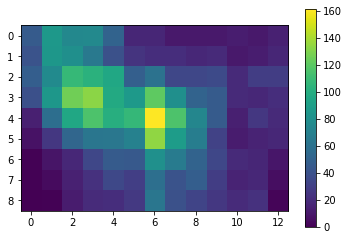

In [43]:
kois, stellar = dataprocessing.get_paired_kepler_catalogs()
period_bins = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp_bins = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
log_p_bins, log_r_bins = np.log(period_bins), np.log(rp_bins)
log_p_bins = np.append(log_p_bins, float('inf'))
log_r_bins = np.append(log_r_bins, float('inf'))
period_rng = (min(period_bins), max(period_bins))
rp_rng = (min(rp_bins), max(rp_bins))

f = np.histogram2d(kois.koi_period, kois.koi_prad, bins=[period_bins, rp_bins])[0] / len(stellar)
lam = np.sum(f)
plt.imshow(np.histogram2d(kois.koi_period, kois.koi_prad, bins=[period_bins, rp_bins])[0])
plt.colorbar()

Text(0.5, 1.0, 'pcomps')

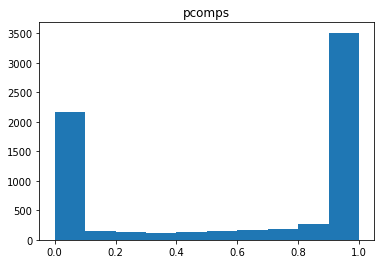

In [13]:
combined = pd.merge(kois, stellar, on='kepid')
precomp_params = completeness.get_precomp_params()
cosincls = np.cos(np.pi * combined['koi_incl'].values / 180)
pcomp = completeness.get_pcomp(combined['koi_period'].values, combined['koi_prad'].values, 
                  combined['koi_eccen'].values, cosincls, combined, precomp_params)
plt.hist(pcomp[~np.isnan(pcomp)])
plt.title("pcomps")

307 detected planets


Text(0.5, 1.0, 'Planet radii')

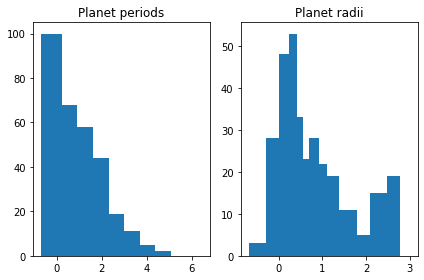

In [23]:
num_stars = len(stellar)
stellar_sample = stellar.sample(n=num_stars)
want_to_save = False
st, pl = abc_occurrence.generate_planet_catalog(f, stellar_sample, log_p_bins, log_r_bins)
if len(stellar_sample) == len(stellar) and want_to_save:
    pl.to_csv('../data/catalog_synth.csv')
print('{0} detected planets'.format(sum(pl.is_detected)))
detected_planets = pl[pl.is_detected]

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist(np.log(detected_planets.period), bins=log_p_bins)
axs[0].set_title("Planet periods")
axs[1].hist(np.log(detected_planets.prad), bins=log_r_bins)
axs[1].set_title("Planet radii")

Difference statistic: 8.756084080755966e-06


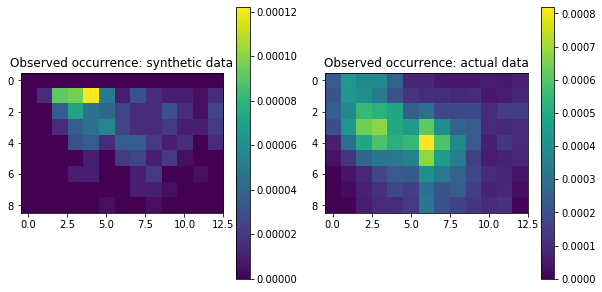

In [30]:
N = np.zeros_like(f)
detected = pl[pl.is_detected]
period_inds = np.digitize(np.log(detected.period), log_p_bins)
radius_inds = np.digitize(np.log(detected.prad), log_r_bins)
for i, j in zip(period_inds, radius_inds):
    if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
        N[i][j] += 1
        
N /= len(stellar_sample)

sample_N = np.histogram2d(kois.koi_period, kois.koi_prad, bins=[period_bins, rp_bins])[0] / len(stellar)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
synth = axs[0].imshow(N)
axs[0].set_title("Observed occurrence: synthetic data")
fig.colorbar(synth, ax=axs[0])
actual = axs[1].imshow(sample_N)
axs[1].set_title("Observed occurrence: actual data")
fig.colorbar(actual, ax=axs[1])

print("Difference statistic: {0}".format(np.sum((N - sample_N) ** 2)))

In [50]:
stellar_sample = stellar.sample(n=100)
sampler = abc_occurrence.OccurrenceABCSampler(period_bins, rp_bins, stellar_sample)
kois_abc = abc_occurrence.kois_to_synth_catalog(period_bins, rp_bins, kois=kois, stellar=stellar)
abc_f = sampler.sample(kois_abc, threshold=3e-3, verbose=True)

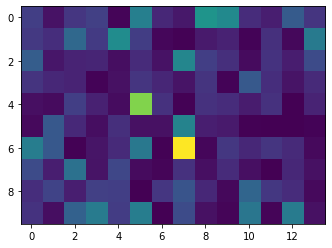

In [51]:
plt.imshow(abc_f.reshape((len(period_bins), len(rp_bins))))

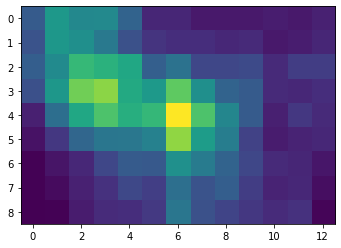

In [52]:
plt.imshow(f)

In [ ]:
abc_pmc_f = OccurrenceABCSampler.sample_pmc(kois_abc, [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 2)